In [1]:
from collections import defaultdict
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from config import get_case_config, get_case_sensitivities
# import sensitivity, utils
# from strategies import RETURN_KEYS

import sys; sys.path.append("../scripts/charts")
from chart_books import *

In [2]:
def config_files(folder):
    return filter(lambda x: x.startswith("config") and x.endswith('.json'), os.listdir(folder))

def run_fname(cfg_fname):
    return cfg_fname.replace("config", "run").replace("json", 'csv')

def resgen(data_dir):
    lockdowns = next(os.walk(data_dir))[1]
    for lockdown in lockdowns:
        folder = os.path.join(data_dir, lockdown)
        for cfg_file in config_files(folder):
            cfg = utils.read_json(os.path.join(folder, cfg_file))
            target = cfg[sensitivity.TARGET_KEY]
            results = pd.read_csv(os.path.join(folder, run_fname(cfg_file)), index_col=0)
            yield lockdown, target, cfg[sensitivity.CONFIG_KEY], results

In [3]:
from tti_explorer import utils, config
keys_to_plot = [RETURN_KEYS.reduced_r, RETURN_KEYS.tests]
rc_dct = {
    'figure.figsize': (7, 6),
    'figure.max_open_warning': 1000,
    "errorbar.capsize": 2.5,
    'font.size': 16
#     "errorbar.capwidth": 2.5
}
plt.rcParams.update(rc_dct)
chart_folder = os.path.join(os.environ['REPOS'], 'tti-explorer', 'outputs', 'charts', 'full-compliance')
input_folder = os.path.join(os.environ['DATA'], "tti-explorer", "new_results", 'full-compliance')

In [13]:
# measures_order =  [
#      'no_TTI',
#     'symptom_based_TTI',
#      'test_based_TTI',
#      'test_based_TTI_test_contacts',
# ]


def errorbar(ax, xaxis, means, stds, label):
    conf_intervals = 1.96 * stds
    ax.errorbar(xaxis, means, yerr=conf_intervals, fmt="o-", label=label, lw=1)
    ax.set_xticks(xaxis)
    ax.set_xticklabels(xaxis)


def arrange_sim_results(sim_results, key):
    xvals, reslist = zip(*sim_results)
    reslist = [k.set_index(STATISTIC_COLNAME, drop=True) for k in reslist]
    arg_order = np.argsort(xvals)
    xaxis = np.array(xvals)[arg_order]
    means, standard_errors = take_key(reslist, key)
    values = means[arg_order]
    return xaxis, values, standard_errors[arg_order]


measures_order = [
    'test_based_TTI'
]


def legend(ax, **kwds):
    defaults = dict(
        loc="best",
        frameon=True,
        framealpha=0.5,
        fancybox=False,
        fontsize=12
    )
    defaults.update(kwds)
    return ax.legend(**defaults)


def plot_lockdown(plotter, lockdown_dct, deck, key_to_plot, order, formatters={}, title=False):
    for param_name, sim_results in lockdown_dct.items():
        tick_formatter = formatters.get(param_name)
        fig, ax = plt.subplots(1)
        for measure in order:
            xaxis, means, std_errs = arrange_sim_results(sim_results[measure], key_to_plot)
            plotter(ax, xaxis, means, std_errs, label=nice_lockdown_name(measure))
        legend(ax)
        if title:
            ax.set_title(param_name)
        ax.set_ylabel(key_to_plot, fontsize=14)
        ax.set_xlabel(nice_param_name(param_name))
        if tick_formatter is not None:
            ax.xaxis.set_major_formatter(tick_formatter)
        deck.add_figure(fig, name=param_name+"_"+key_to_plot.lower().replace(" ", "_").replace("%", ""))
    return fig

In [14]:
from matplotlib.ticker import FuncFormatter
perc_formatter = FuncFormatter(lambda x, _: f"{100*x:.0f}%")
formatters = {
    'app_cov': perc_formatter,
    'trace_adherence': perc_formatter    
}
plt.style.use("seaborn-ticks")

# Pinch Points

In [15]:
pinch_points_dir = os.path.join(input_folder, "app-cov-perc-prevented")
pinch_points_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for lockdown, target, cfg, results in resgen(pinch_points_dir):
    target = target[0]
    if target in ['testing_delay', 'manual_trace_delay']:
        continue
    if int(lockdown[1]) > 0:
        level, measures = lockdown.split('_', maxsplit=1)
        pinch_points_results[level][target][measures].append((cfg[target], results))

In [16]:
pinch_points_results[level][target][measures][0][1]

,statistic,Base R,Effective R,# Manual Traces,# App Traces,# Tests Needed,# PersonDays Quarantined,% of Ongoing Transmission Prevented by Social Distancing,% of Ongoing Transmission Prevented by Isolating Cases with Symptoms and Quarantining Households,% of Ongoing Transmission Prevented by Tracing,% of Ongoing Transmission Allowed Through by TTI Policy
scenario,,,,,,,,,,,
oxteam-symptomatic_seed0,mean,4.851031,0.986443,245.888400,289.072800,95.965200,4300.056000,3.083820e+01,4.713154e+01,1.291918e+01,9.111086e+00
oxteam-symptomatic_seed0,std,0.044387,0.019261,4.612872,5.578518,0.151873,64.548277,3.261296e-11,6.219500e-11,1.279538e-11,6.612799e-12


In [17]:
RETURN_KEYS.__dict__

{'base_r': 'Base R',
 'reduced_r': 'Effective R',
 'man_trace': '# Manual Traces',
 'app_trace': '# App Traces',
 'tests': '# Tests Needed',
 'quarantine': '# PersonDays Quarantined',
 'covid': 'Has Covid',
 'symptomatic': 'Is Symptomatic',
 'tested': 'Got tested',
 'secondary_infections': '# Secondary Infections',
 'cases_prevented_social_distancing': '# Secondary Infections Prevented by Social Distancing',
 'cases_prevented_symptom_isolating': '# Secondary Infections Prevented by Isolating Cases with Symptoms',
 'fractional_r': 'Fractional R',
 'stopped_by_social_distancing_percentage': '% of Ongoing Transmission Prevented by Social Distancing',
 'stopped_by_symptom_isolating_percentage': '% of Ongoing Transmission Prevented by Isolating Cases with Symptoms and Quarantining Households',
 'stopped_by_tracing_percentage': '% of Ongoing Transmission Prevented by Tracing',
 'not_stopped_by_tti': '% of Ongoing Transmission Allowed Through by TTI Policy',
 'percent_primary_symptomatic_miss

In [18]:
keys_to_plot = [
    RETURN_KEYS.stopped_by_social_distancing_percentage,
    RETURN_KEYS.stopped_by_symptom_isolating_percentage,
    RETURN_KEYS.stopped_by_tracing_percentage,
    RETURN_KEYS.not_stopped_by_tti,
]

<ipython-input-20-e5b7efda7d5f>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
<ipython-input-20-e5b7efda7d5f>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
<ipython-input-20-e5b7efda7d5f>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
<ipython-input-20-e5b7efda7d5f>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
<ipython-input-20-e5b7efda7d5f>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


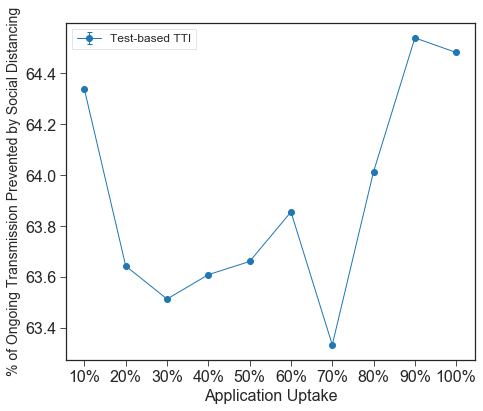

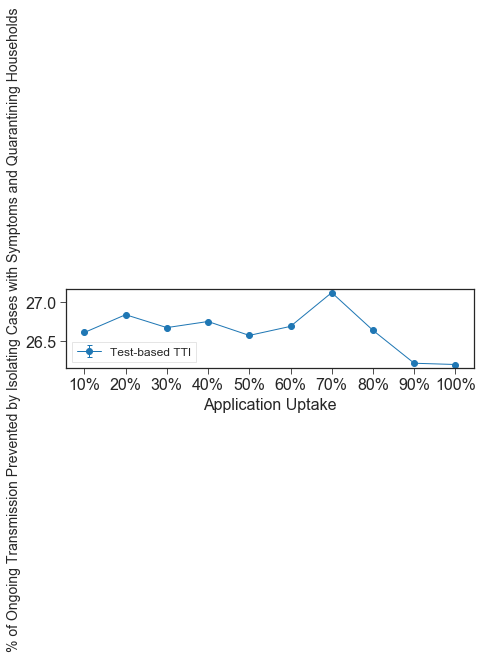

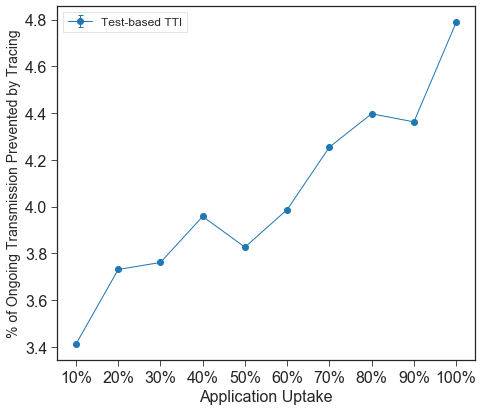

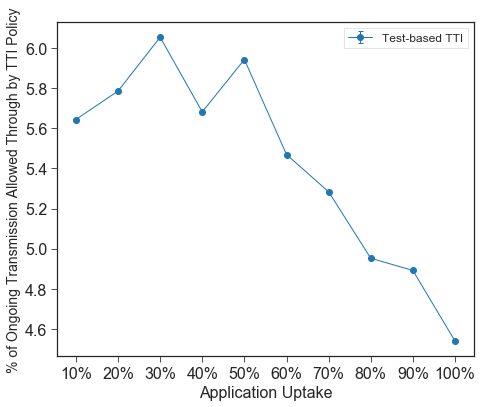

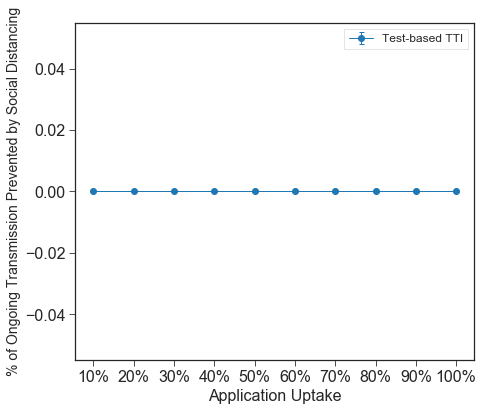

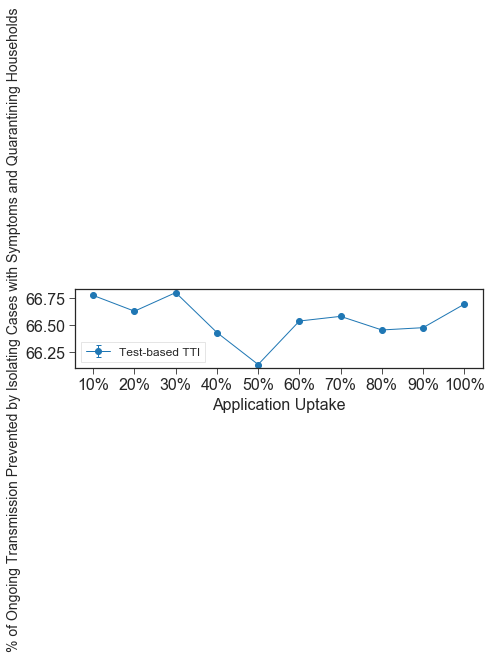

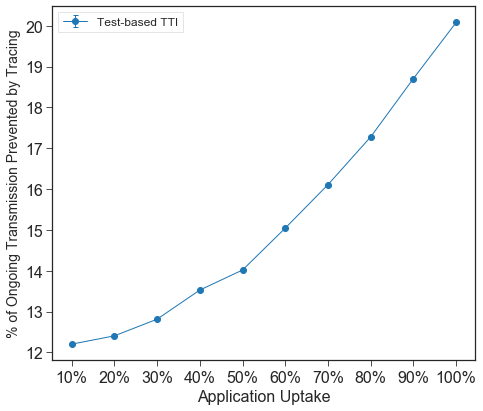

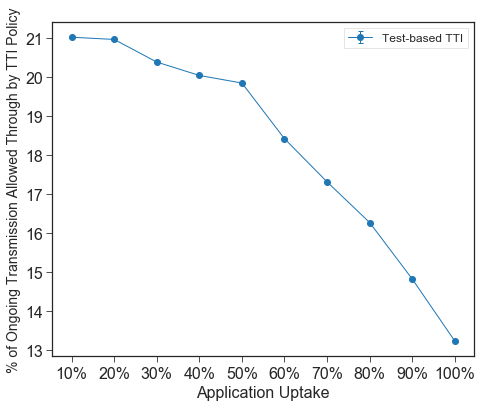

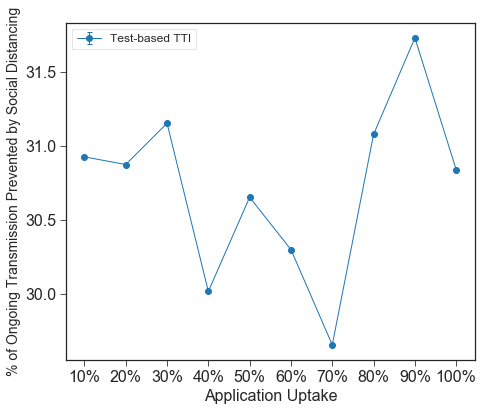

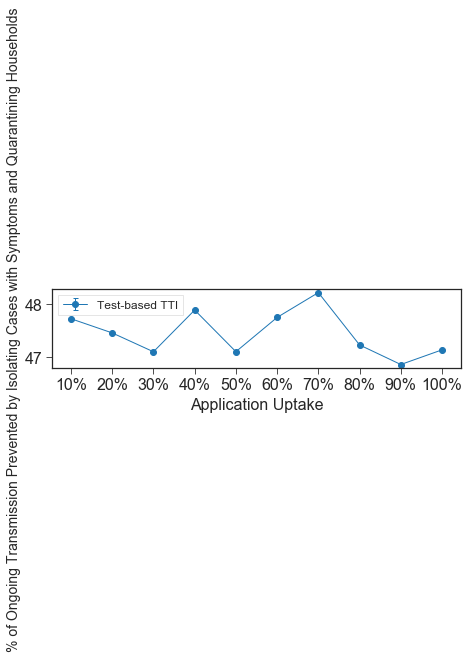

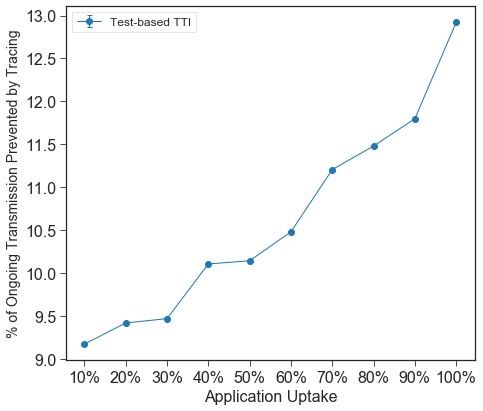

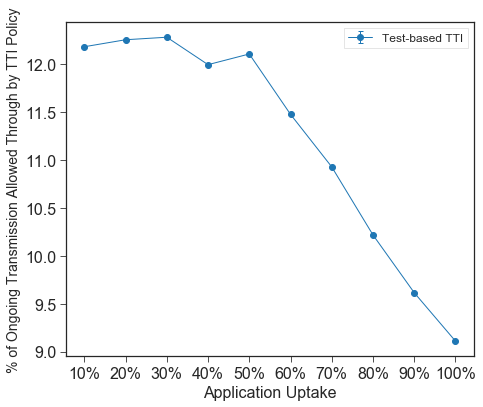

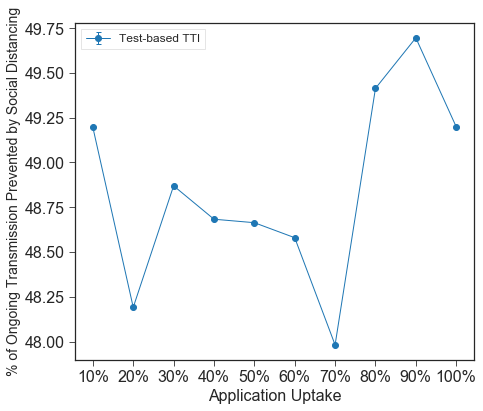

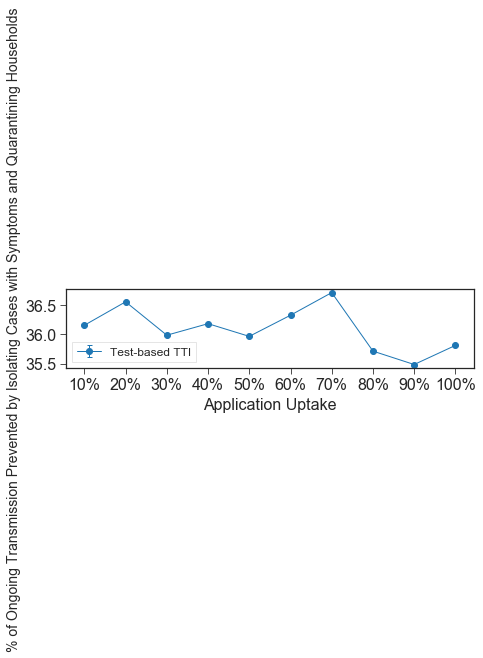

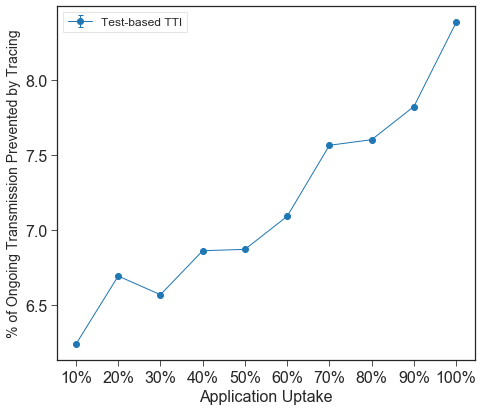

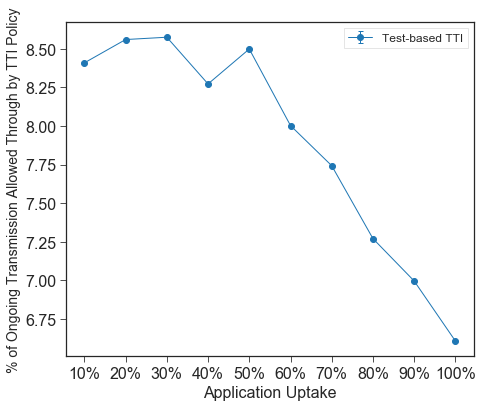

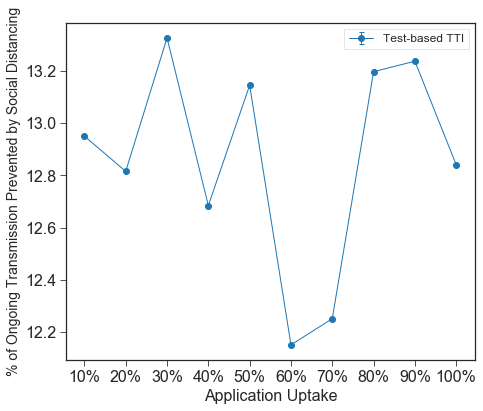

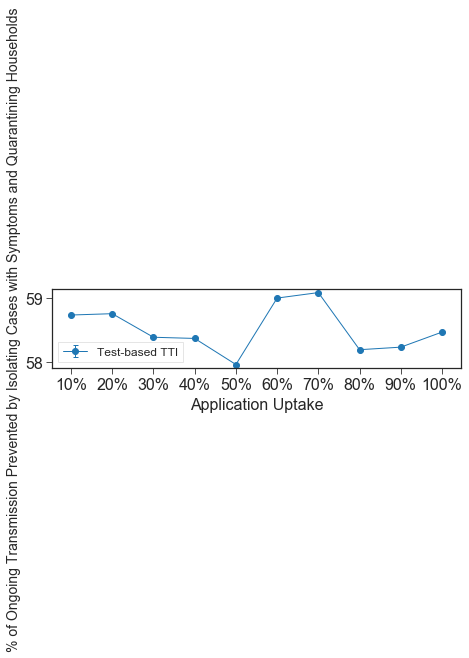

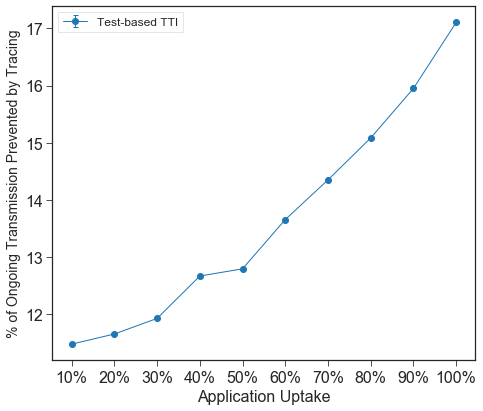

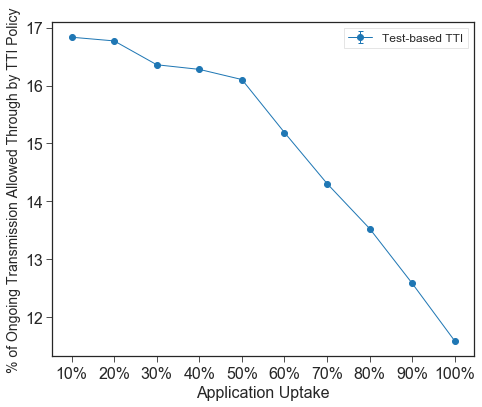

In [20]:
with plt.rc_context(rc_dct):
    for level, results in pinch_points_results.items():
        deck = utils.PdfDeck()
        for key in keys_to_plot:
            plot_lockdown(errorbar, results, deck, key, order=measures_order, formatters=formatters)
            for fig in deck.figs:
                fig.tight_layout()
#                 fig.axes[0].set_title(level) ### remove this!
        deck.make(os.path.join(chart_folder, f"{level}_pinch_points.pdf"))
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)

## Area charts

In [23]:
means = dict()
perc_keys = [
    RETURN_KEYS.stopped_by_social_distancing_percentage,
    RETURN_KEYS.stopped_by_symptom_isolating_percentage,
    RETURN_KEYS.stopped_by_tracing_percentage,
    RETURN_KEYS.not_stopped_by_tti,
]
param_name = 'app_cov'
measure = 'test_based_TTI'
for level, results in pinch_points_results.items():
        res = results[param_name][measure]
        mdict = dict()
        for key in perc_keys:
            x, m, std_errs = arrange_sim_results(res, key)    
            mdict[key] = m 
        df = pd.DataFrame(mdict, index=x) / 100
        df.index.name = nice_param_name(param_name)
        means[level] = df

In [24]:
def renamer(s):
    return s.replace(
        "Secondary Infections",
        "Ongoing Transmission"
    ).replace(
        "Secondary Infection",
        "Ongoing Transmission"
    )

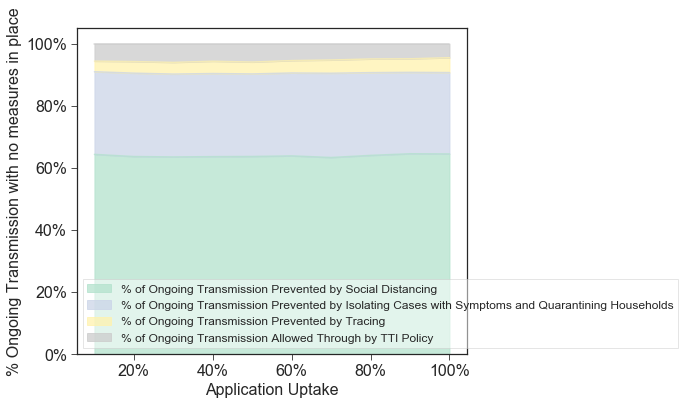

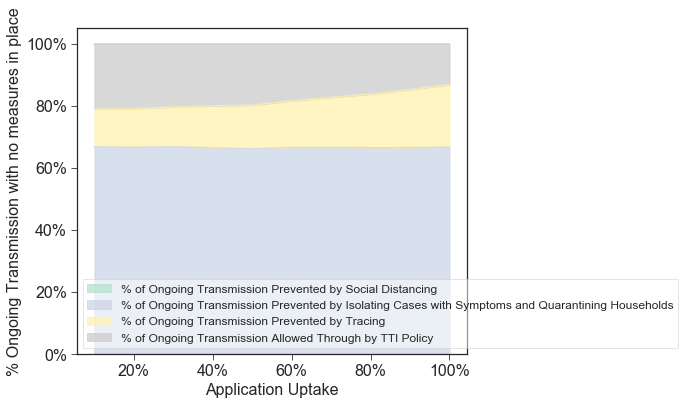

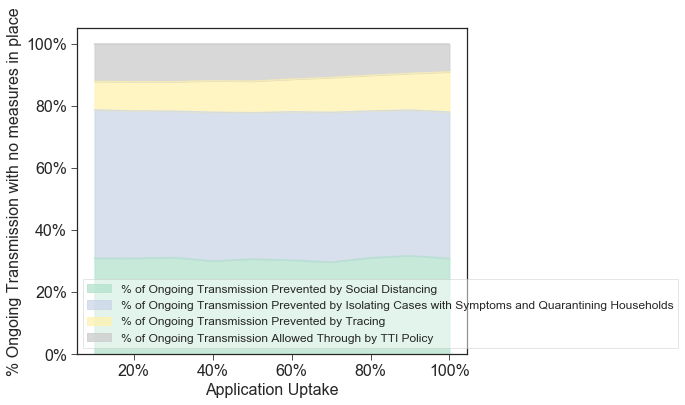

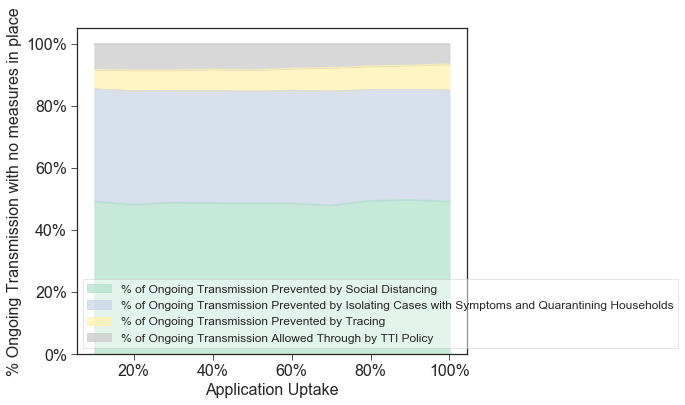

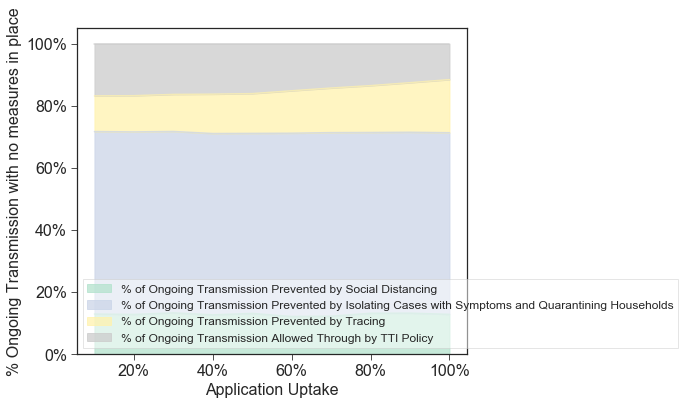

In [25]:
for level, areas in means.items():
    ax = areas.rename(columns=renamer).plot.area(colormap=plt.get_cmap('Pastel2'), alpha=0.75)
    leg = legend(ax, framealpha=0.5, fontsize=12, loc="lower left")
#     ax.set_title(level)
    lab = ax.set_ylabel("% Ongoing Transmission with no measures in place")
    ax.yaxis.set_major_formatter(perc_formatter)
    ax.xaxis.set_major_formatter(perc_formatter)
    plt.savefig(os.path.join(chart_folder, f"{level}_individual", "app_cov_area.pdf"),
                format="pdf", bbox_extra_artists=[lab, leg], bbox_inches="tight")

# Test Trace Tables

In [13]:
def make_tables(entry, key):
    coords, reslist = zip(*entry)
    means, stds = zip(*[(k[key]['mean'], k[key]['std']) for k in reslist])
    means_mat = pd.DataFrame(np.array(utils.sort_by(means, coords, return_idx=False)).reshape(3, 3))
    stds_mat = pd.DataFrame(np.array(utils.sort_by(stds, coords, return_idx=False)).reshape(3, 3))
    return means_mat, stds_mat


def format_table(means, stds):
    t1, t2 = ['TTI Delay (days)', 'NPI severity']

    table = means.applymap(
            lambda x: f"{x:.2f}"
        ).add(
            " \pm "
        ).add(
            stds.mul(
                1.96 # check michaels code
            ).applymap(
                lambda x: f"{x:.2f}"
            )
        ).applymap(lambda x: f"${x}$")
    new_order = [[2,2], [2,1], [1,2], [2,0], [1,1], [0,2], [1,0], [0,1], [0,0]]
    new_order = list(tuple(x) for x in new_order)
    table.index = ['No TTI'] + new_order
    table.columns = sorted(test_trace_results.keys(), reverse = True)
    table.index.name = t1
    table.columns.name = t2
    return table


def format_mean_only(means):
    t1, t2 = ['TTI Delay (days)', 'NPI severity']

    table = means.applymap(
            lambda x: f"{x:.0f}\%"
        )
    new_order = [[2,2], [2,1], [1,2], [2,0], [1,1], [0,2], [1,0], [0,1], [0,0]]
    new_order = list(tuple(x) for x in new_order)
    table.index = ['No TTI'] + new_order
    table.columns = sorted(test_trace_results.keys(), reverse = True)
    table.index.name = t1
    table.columns.name = t2
    return table
    

def make_new_tables(big_dict, name='test_based_TTI'):
    new_order = [[2,2], [2,1], [1,2], [2,0], [1,1], [0,2], [1,0], [0,1], [0,0]]
    mean_mat = np.zeros((10, 5))
    stds_mat = np.zeros((10, 5))
    no_tti, test_based_tti = ('no_TTI', name)
    s_levels = sorted(test_trace_results.keys(), reverse = True)
    for s_idx, s_level in enumerate(s_levels):
        mean_mat[0, s_idx] = big_dict[s_level][no_tti]['means'].iloc[0].loc[0]
        stds_mat[0, s_idx] = big_dict[s_level][no_tti]['stds'].iloc[0].loc[0]
        for new_row_idx, (row_idx, col_idx) in enumerate(new_order):
            mean_mat[new_row_idx+1, s_idx] = big_dict[s_level][test_based_tti]['means'].iloc[row_idx].loc[col_idx]
            stds_mat[new_row_idx+1, s_idx] = big_dict[s_level][test_based_tti]['stds'].iloc[row_idx].loc[col_idx]
    mean_mat = pd.DataFrame(mean_mat, columns = s_levels)
    stds_mat = pd.DataFrame(stds_mat, columns = s_levels)
    return mean_mat, stds_mat
    

In [14]:
perc_keys = [
    RETURN_KEYS.stopped_by_social_distancing_percentage,
    RETURN_KEYS.stopped_by_symptom_isolating_percentage,
    RETURN_KEYS.stopped_by_tracing_percentage,
    RETURN_KEYS.not_stopped_by_tti,
]

In [15]:
tt_dir = os.path.join(input_folder, "test-trace-perc-prevented")
test_trace_results = defaultdict(lambda: defaultdict(list))
for lockdown, target, cfg, results in resgen(tt_dir):
    if int(lockdown[1]) > 0:
        vals = [cfg[k] for k in target]
        level, measures = lockdown.split('_', maxsplit=1)
        results = results.set_index(config.STATISTIC_COLNAME, drop=True)
        test_trace_results[level][measures].append((vals, results))  

In [16]:
def increment_tup(tup):
    return tuple(k+1 for k in tup) if isinstance(tup, tuple) else tup

In [17]:
table_deck = utils.LatexTableDeck()

In [18]:
name = "test_based_TTI"
big_dict = defaultdict(dict)
for key in perc_keys:
    for k in sorted(list(test_trace_results.keys())):
        for policy, entry in test_trace_results[k].items():
            if policy in [name, "no_TTI"]:
                means, stds = make_tables(entry, key=key)
                big_dict[k][policy] = {"means": means, "stds": stds} #turn this into dfs
    mean_mat, stds_mat = make_new_tables(big_dict, name=name)
    table_str = format_mean_only(mean_mat).rename(index=increment_tup).to_latex(escape=False)
    table_deck.add_table(
        tex_table=table_str,
        caption=nice_lockdown_name(policy) + " " + key.replace("%", "\%")
    )

In [19]:
c_folder = "/Users/bryn/Programming/repos/tti-explorer/outputs/charts"

In [20]:
table_deck.make(os.path.join(chart_folder, "test-trace-perc-prevented.tex"))

In [20]:
# two charts for covid and flue like
# do num tests and num contact tracings needed for infection proportions

In [21]:
assert False

AssertionError: 

In [ ]:
# table_deck = utils.LatexTableDeck()

# for k in sorted(test_trace_results.keys()):
#     table_deck.add_section(f"Lockdown Level {k}")
#     for policy, entry in test_trace_results[k].items():
#         means, stds = make_tables(entry, key=RETURN_KEYS.reduced_r)
#         table = format_table(means, stds)
#         table_deck.add_table(
#             tex_table=table.to_latex(escape=False),
#             caption=nice_lockdown_name(policy)
#         )
#     table_deck.clearpage()
# table_deck.make("test-trace-tables.tex")

# Sensitivity

In [ ]:
inf_props_mapping = {
     'oxteam_infection_proportions0_seed0': "vary_flu0",
     'oxteam_infection_proportions1_seed0': "vary_flu1",
     'oxteam_infection_proportions2_seed0': "vary_flu2",
     'oxteam_infection_proportions3_seed0': "vary_flu3",
     'oxteam_infection_proportions4_seed0': "vary_covid0",
     'oxteam_infection_proportions5_seed0': "vary_covid1",
     'oxteam_infection_proportions6_seed0': "vary_covid2"
}

In [ ]:
def make_tables(entry, key=RETURN_KEYS.reduced_r):
    coords, reslist = zip(*entry)
    means, stds = zip(*[(k[key]['mean'], k[key]['std']) for k in reslist])
    means_mat = pd.DataFrame(np.array(utils.sort_by(means, coords, return_idx=False)).reshape(3, 3))
    stds_mat = pd.DataFrame(np.array(utils.sort_by(stds, coords, return_idx=False)).reshape(3, 3))
    return means_mat, stds_mat


def format_table(means, stds):
    t1, t2 = ['Test Delay (days)', 'Manual Trace Delay (days)']

    table = means.applymap(
            lambda x: f"{x:.2f}"
        ).add(
            " \pm "
        ).add(
            stds.mul(
                1.96 
            ).applymap(
                lambda x: f"{x:.2f}"
            )
        ).applymap(lambda x: f"${x}$")
    
    table.index =  range(1, 4)
    table.columns = range(1, 4)
    table.index.name = t1
    table.columns.name = t2
    return table

In [ ]:
case_sensitivity_results = defaultdict(dict)
case_sensitivity_dir = os.path.join(input_folder, 'case-sensitivity-quick')
for lockdown, target, cfg, results in resgen(case_sensitivity_dir):
    if lockdown[1] == '0': 
        continue
    level, measures = lockdown.split("_", maxsplit=1)
    # just load all the run_dfs and concat them...
    folder = os.path.join(case_sensitivity_dir, lockdown)
    runs = [
        pd.read_csv(
        os.path.join(folder, fname),
        index_col=0
    )
    for fname in os.listdir(folder) if fname.startswith("run") and fname.endswith(".csv")
    ]
    case_sensitivity_results[level][measures] = pd.concat(
        runs,
        axis=0
    ).drop('oxteam_infection_proportions7_seed0').rename(index=inf_props_mapping)

In [ ]:
case_sensitivity_results[level][measures]

In [ ]:
import config

k_formatter = FuncFormatter(lambda x, _: f"{x:.0f}k")

class LockdownSensitivityPlotter:
    # BE: need to sort out this naming bullshit
    def __init__(self):
        self.ticklabel_maps = {
            'inf_profile': np.array([f"{int(x)}" for x in (np.array([2.11, 2.8, 3.49]) - 1)/0.69]),
             'vary_flu': np.array([f"{k}k" for k in [50, 100, 200, 300]]),
             'vary_covid': np.array([f"{k}k" for k in [10, 20, 30]]),
             'p_day_noticed_symptoms': (np.array([2, 3, 4]) - 1).astype(str),
        }
        self.xlabels = {
             'inf_profile': "Day on which primary case is most infectious",
             'vary_flu': "# COVID negative cases with COVID like symptoms (daily)",
             'vary_covid': "# COVID positive cases (daily)",
             'p_day_noticed_symptoms': (
             "Expected number of days"
             )
        }
        self.param_map = {
                 'oxteam_inf_profile11_seed0': 0,
                 'oxteam_inf_profile12_seed0': 1,
                 'oxteam_inf_profile13_seed0': 2,
                 'oxteam_p_day_noticed_symptoms10_seed0': 0,
                 'oxteam_p_day_noticed_symptoms8_seed0': 2,
                 'oxteam_p_day_noticed_symptoms9_seed0': 1,
                 'vary_flu0': 0,
                 'vary_flu1': 1,
                 'vary_flu2': 2,
                 'vary_flu3': 3,
                 'vary_covid0': 0,
                 'vary_covid1': 1,
                 'vary_covid2': 2
            }
        
        self.y_formatters = {'vary_covid': k_formatter, 'vary_flu': k_formatter}
        
    def _grouper(self, s):  ## not neat!
        for i in range(10):
            s = s.replace(f"{i}", "")
        return s.replace("oxteam_", "").replace("_seed", "")
    
    def _plot_parameter(self, ax, results_df, key):
        for measure, dfstats in results_df[[key, config.STATISTIC_COLNAME]].groupby(level=0):
            dfstats = dfstats.droplevel(0).rename(self.param_map).sort_index()
            mean = dfstats.query(
                f"{config.STATISTIC_COLNAME}=='mean'"
            ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
            std = dfstats.query(
                f"{config.STATISTIC_COLNAME}=='std'"
            ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
            xaxis = mean.index.values
            errorbar(ax, xaxis, mean.values, std.values, label=nice_lockdown_name(measure))
        return xaxis
            
    def __call__(self, results, deck, keys_to_plot):
        by_param = pd.concat(results, axis=0).groupby(level=1, by=self._grouper)
        for param_name, v in by_param:
            fig, ax = plt.subplots(1)
            xaxis = self._plot_parameter(ax, v, keys_to_plot[param_name])
            ax.set_xticks(xaxis)
            ax.set_xticklabels(self.ticklabel_maps[param_name][xaxis])
            ax.set_xlabel(self.xlabels[param_name])
            ax.set_ylabel(keys_to_plot[param_name])
            formatter = self.y_formatters.get(param_name, None)
            if formatter is not None:
                ax.yaxis.set_major_formatter(formatter)
            legend(ax)
            deck.add_figure(fig, name=param_name)
            

In [ ]:
# self = plotter
# key = RETURN_KEYS.reduced_r
# by_param = pd.concat(results, axis=0).groupby(level=1, by=self._grouper)
# for param_name, results_df in by_param:
#     for measure, dfstats in results_df[[key, config.STATISTIC_COLNAME]].groupby(level=0):
#         break
#         dfstats = dfstats.droplevel(0).rename(self.param_map)
#         mean = dfstats.query(
#             f"{config.STATISTIC_COLNAME}=='mean'"
#         ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
#         std = dfstats.query(
#             f"{config.STATISTIC_COLNAME}=='std'"
#         ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
#         xaxis = mean.index.values
#         errorbar(ax, xaxis, mean.values, std.values, label=nice_lockdown_name(measure))

In [ ]:
keys_to_plot = {
    'inf_profile': RETURN_KEYS.reduced_r,
    'p_day_noticed_symptoms': RETURN_KEYS.reduced_r,
    'vary_covid': RETURN_KEYS.tests,
    'vary_flu': RETURN_KEYS.tests
}

with plt.rc_context(rc_dct):
    plotter = LockdownSensitivityPlotter()
    for level, results in case_sensitivity_results.items():
        deck = utils.PdfDeck()
        plotter(results, deck, keys_to_plot)
        deck.make(os.path.join(chart_folder, f"{level}_sensitivity.pdf"))
        for fig in deck.figs:
            fig.tight_layout()
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)